<a href="https://colab.research.google.com/github/YUseiDoi/Spectral_Clustering/blob/main/Karate_Club_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## モジュール

In [27]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from scipy.linalg import fractional_matrix_power
from enum import Enum

## データ確認

Node Degree
   0     16
   1      9
   2     10
   3      6
   4      3
   5      4
   6      4
   7      4
   8      5
   9      2
  10      3
  11      1
  12      2
  13      5
  14      2
  15      2
  16      2
  17      2
  18      2
  19      3
  20      2
  21      2
  22      2
  23      5
  24      3
  25      3
  26      2
  27      4
  28      3
  29      4
  30      4
  31      6
  32     12
  33     17


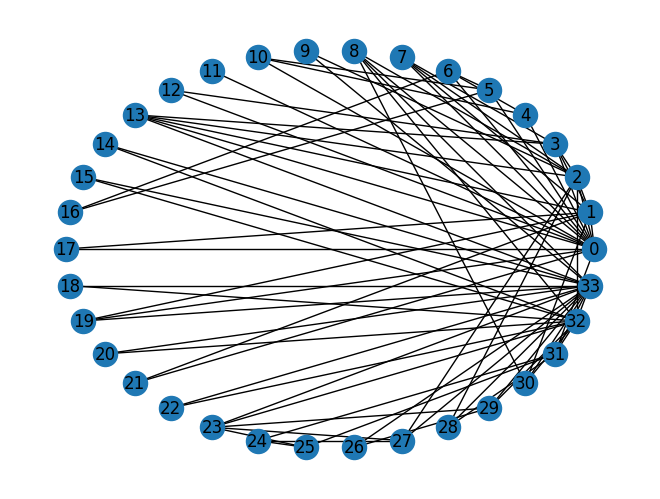

In [2]:
# データ読み込み
G = nx.karate_club_graph()
print("Node Degree")
g_node = {}
for v in G:
    print(f"{v:4} {G.degree(v):6}")
    g_node[v] = G.degree(v)

nx.draw_circular(G, with_labels=True)
plt.show()

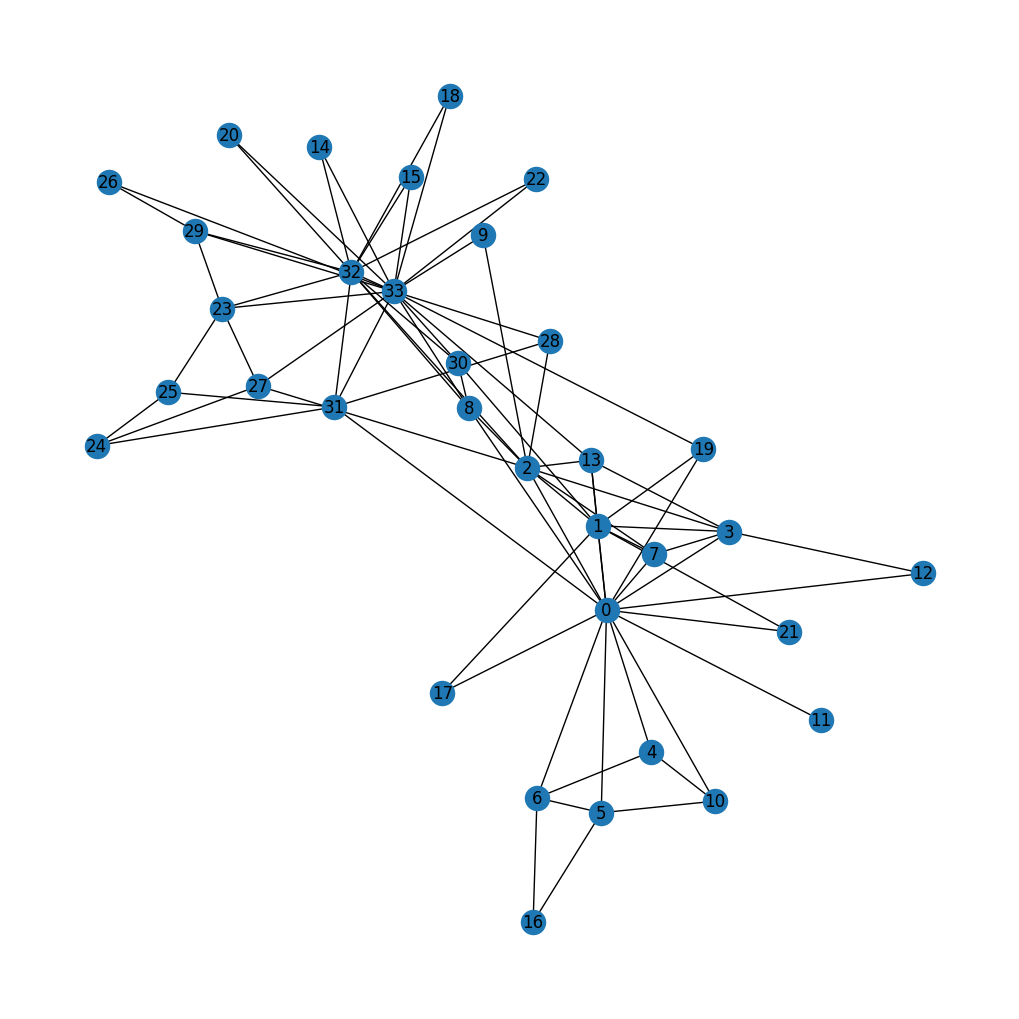

In [3]:
pos = nx.spring_layout(G) # 可視化のレイアウト
plt.figure(figsize=(10,10)) # 可視化のサイズ
nx.draw(G, pos=pos, with_labels=True) # 可視化

In [4]:
print(nx.adjacency_matrix(G).toarray())

[[0 4 5 ... 2 0 0]
 [4 0 6 ... 0 0 0]
 [5 6 0 ... 0 2 0]
 ...
 [2 0 0 ... 0 4 4]
 [0 0 2 ... 4 0 5]
 [0 0 0 ... 4 5 0]]


In [5]:
print(len(G)) # ノード数
print(G.size()) # リンク数

34
78


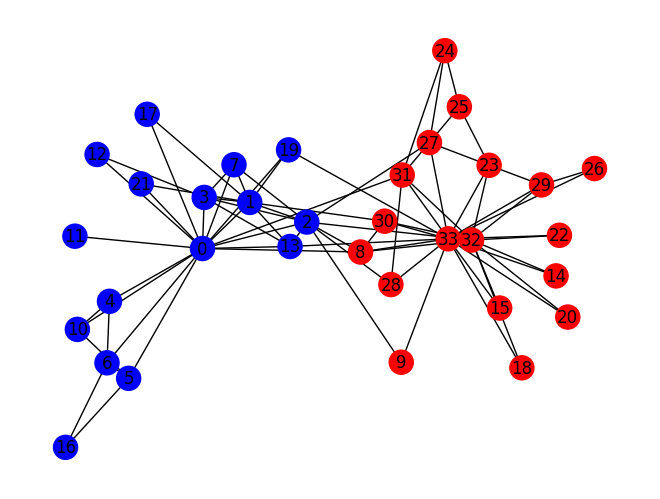

In [6]:
# 実際に分裂した時の様子
true_group_idx = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
# ノードの色を決定するためのマッピング
color_map = {0: 'blue', 1: 'red'}

pos = nx.spring_layout(G) # 可視化のレイアウト

# nx.draw()関数のnode_color引数にリストを渡す
nx.draw(G, pos=pos, with_labels=True,
        node_color=[color_map[c] for c in true_group_idx])

## 隣接行列・次数行列・グラフラプラシアンの取得

In [7]:
# 隣接行列の取得
adjacency_matrix = nx.adjacency_matrix(G).toarray()
A_list = []
for row in adjacency_matrix:
  A_list.append([1 if x > 0 else 0 for x in row])
A = np.array(A_list)
#A = adjacency_matrix
print(A)

[[0 1 1 ... 1 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 1 0]
 ...
 [1 0 0 ... 0 1 1]
 [0 0 1 ... 1 0 1]
 [0 0 0 ... 1 1 0]]


In [8]:
# 次数行列の取得
D = np.zeros((34, 34))
node_num = 34
for i in range(node_num):
  D[i][i] = g_node[i]
print(D)

[[16.  0.  0. ...  0.  0.  0.]
 [ 0.  9.  0. ...  0.  0.  0.]
 [ 0.  0. 10. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  6.  0.  0.]
 [ 0.  0.  0. ...  0. 12.  0.]
 [ 0.  0.  0. ...  0.  0. 17.]]


In [9]:
# グラフラプラシアンの取得
L = D - A
print(L)

[[16. -1. -1. ... -1.  0.  0.]
 [-1.  9. -1. ...  0.  0.  0.]
 [-1. -1. 10. ...  0. -1.  0.]
 ...
 [-1.  0.  0. ...  6. -1. -1.]
 [ 0.  0. -1. ... -1. 12. -1.]
 [ 0.  0.  0. ... -1. -1. 17.]]


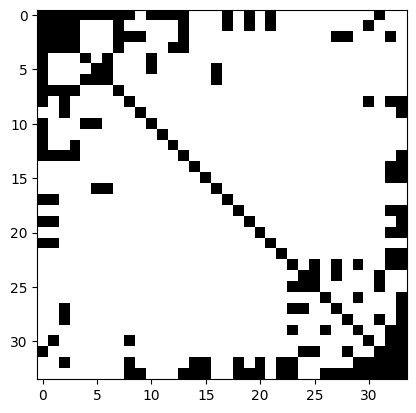

In [10]:
# グラフラプラシアンの描画
array = np.where(L==0, 255, 0)

# 画像として表示
plt.imshow(array, cmap='gray', vmin=0, vmax=255)
plt.show()

## スペクトラルクラスタリング

In [28]:
# クラスタリングタイプ
class EClusteringType(Enum):
    L_normal = 1
    L_sym = 2
    L_rw = 3

In [43]:
def spectral_clustering(L, K, clustering_type=EClusteringType.L_normal):
  """
  スペクトラルクラスタリングを行う関数

  引数：
      L: numpy.ndarray
        グラフラプラシアン
      K: numpy.ndarray
        クラスタ数
  """
  # 固有値分解
  eigvals, eigvecs = np.linalg.eig(L)
  #print(eigvals_ncut)
  #print(eigvecs_ncut)

  # 固有値と固有ベクトルを昇順にソート
  eig_sorted_idx = np.argsort(eigvals)
  eigvals_sorted = np.array(sorted(eigvals))
  eigvecs_sorted = eigvecs.take(eig_sorted_idx, axis=0)

  # クラスタの数だけ、小さい方から固有値と固有ベクトルを取得する
  eigvecs_kmeans = eigvecs_sorted[1:K+1]
  #print(eigvecs_ncut_kmeans)

  # 固有ベクトルから成る行列を転置する
  eigvecs_kmeans_T = eigvecs_kmeans.T
  #print(eigvecs_ncut_kmeans_T)

  # Lsymの場合のみ、各行ベクトルのノルムを1にする
  if clustering_type == EClusteringType.L_sym:
    norms = np.linalg.norm(eigvecs_kmeans_T, axis=1, keepdims=True)
    eigvecs_kmeans_T = eigvecs_kmeans_T / norms

  # k-meansの実行
  kmeans = KMeans(n_clusters=K).fit(eigvecs_kmeans_T)

  # クラスタリング結果の取得
  labels = kmeans.labels_

  # クラスタの中心の取得
  centers = kmeans.cluster_centers_

  print("Labels: ", labels)
  print("Cluster Centers: ", centers)

  group1 = np.where(labels == 0)[0] + 1
  group2 = np.where(labels == 1)[0] + 1
  print('people in group 1:', group1)
  print('people in group 2:', group2)

  # ノードの色を決定するためのマッピング
  color_map = {0: 'blue', 1: 'red'}

  #pos = nx.spring_layout(G) # 可視化のレイアウト

  # nx.draw()関数のnode_color引数にリストを渡す
  nx.draw(G, pos=pos, with_labels=True,
          node_color=[color_map[c] for c in labels])

In [44]:
# クラス数
K = 2

## 非正規化グラフラプラシアンによるスペクトラルクラスタリング

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Labels:  [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0]
Cluster Centers:  [[-0.03031545  0.02445383]
 [ 0.39908387 -0.05554815]]
people in group 1: [ 1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 23 24 25 26
 27 29 30 31 32 33 34]
people in group 2: [11 22 28]


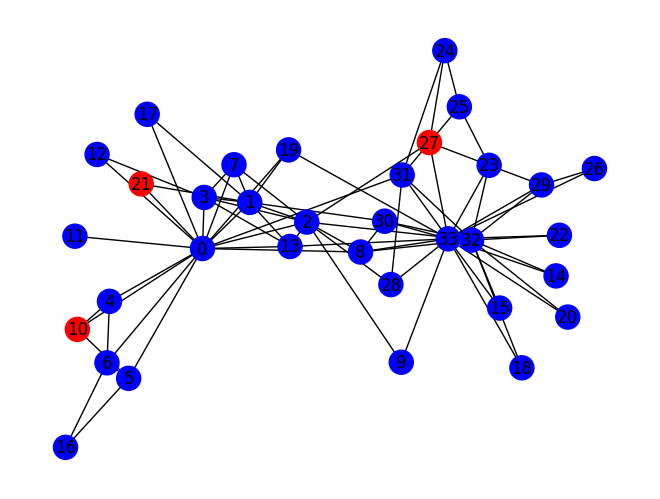

In [45]:
spectral_clustering(L, K, EClusteringType.L_normal)

## 正規化グラフラプラシアンによるスペクトラルクラスタリング

### ノーマライズドカット

In [46]:
# グラフラプラシアンの正規化
D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(D)))
L_ncut = D_inv_sqrt @ L @ D_inv_sqrt
print(L_ncut)

[[ 1.         -0.08333333 -0.07905694 ... -0.10206207  0.
   0.        ]
 [-0.08333333  1.         -0.10540926 ...  0.          0.
   0.        ]
 [-0.07905694 -0.10540926  1.         ...  0.         -0.09128709
   0.        ]
 ...
 [-0.10206207  0.          0.         ...  1.         -0.11785113
  -0.09901475]
 [ 0.          0.         -0.09128709 ... -0.11785113  1.
  -0.070014  ]
 [ 0.          0.          0.         ... -0.09901475 -0.070014
   1.        ]]


In [31]:
D_inv_sqrt = fractional_matrix_power(D, -0.5)
L_ncut = np.identity(D.shape[0]) - D_inv_sqrt @ A @ D_inv_sqrt
print(L_ncut)

[[ 1.         -0.08333333 -0.07905694 ... -0.10206207  0.
   0.        ]
 [-0.08333333  1.         -0.10540926 ...  0.          0.
   0.        ]
 [-0.07905694 -0.10540926  1.         ...  0.         -0.09128709
   0.        ]
 ...
 [-0.10206207  0.          0.         ...  1.         -0.11785113
  -0.09901475]
 [ 0.          0.         -0.09128709 ... -0.11785113  1.
  -0.070014  ]
 [ 0.          0.          0.         ... -0.09901475 -0.070014
   1.        ]]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Labels:  [0 1 0 0 0 1 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
Cluster Centers:  [[-0.42288419  0.42545561]
 [ 0.33988109 -0.72899064]]
people in group 1: [ 1  3  4  5  7  8 11 14 15 16 17 19 20 21 22]
people in group 2: [ 2  6  9 10 12 13 18 23 24 25 26 27 28 29 30 31 32 33 34]


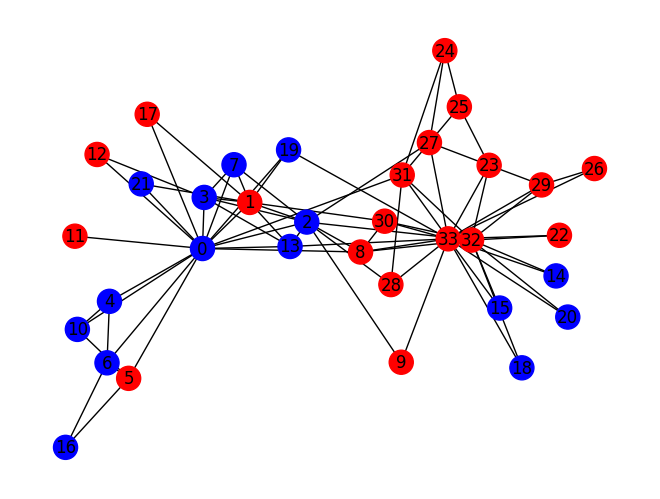

In [47]:
spectral_clustering(L_ncut, K, EClusteringType.L_sym)

### 酔歩正規化グラフラプラシアン

In [48]:
# グラフラプラシアンの正規化
D_inv = np.linalg.inv(D)
L_rand = D_inv @ L
print(L_rand)

[[ 1.         -0.0625     -0.0625     ... -0.0625      0.
   0.        ]
 [-0.11111111  1.         -0.11111111 ...  0.          0.
   0.        ]
 [-0.1        -0.1         1.         ...  0.         -0.1
   0.        ]
 ...
 [-0.16666667  0.          0.         ...  1.         -0.16666667
  -0.16666667]
 [ 0.          0.         -0.08333333 ... -0.08333333  1.
  -0.08333333]
 [ 0.          0.          0.         ... -0.05882353 -0.05882353
   1.        ]]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Labels:  [1 0 0 1 1 1 0 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
Cluster Centers:  [[-0.13941864  0.04141596]
 [ 0.02336586 -0.03465673]]
people in group 1: [ 2  3  7 11 12 14 15 18 19 21 22]
people in group 2: [ 1  4  5  6  8  9 10 13 16 17 20 23 24 25 26 27 28 29 30 31 32 33 34]


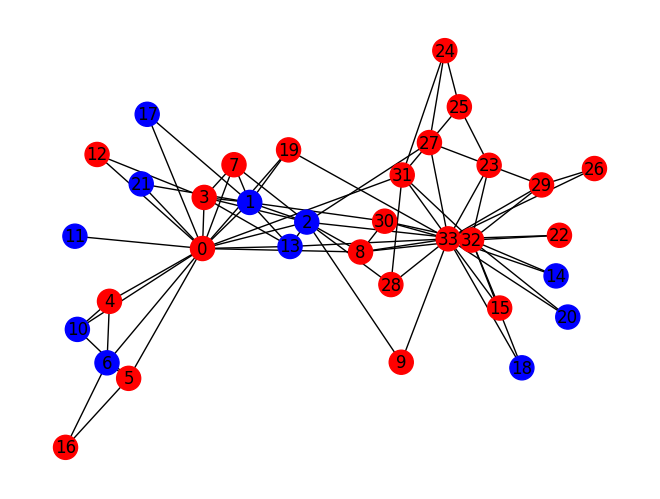

In [53]:
spectral_clustering(L_rand, K, EClusteringType.L_rw)

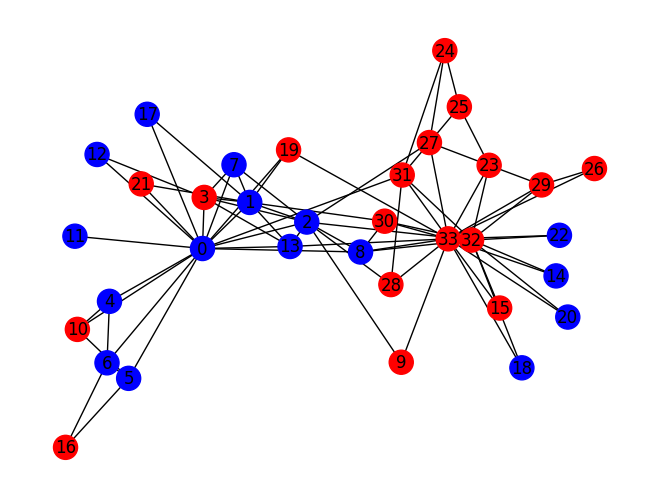

In [20]:
group1_sample = [1, 2, 4, 5, 6, 7, 8,11,12,13,14,17,18,20,22]
group2_sample = [3, 9,10,15,16,19,21,23,24,25,26,27,28,29,30,31,32,33,34]
group_sample = [1 if i in group2_sample else 0 for i in range(34)]
# nx.draw()関数のnode_color引数にリストを渡す
nx.draw(G, pos=pos, with_labels=True,
        node_color=[color_map[c] for c in group_sample])